# Getting Started: Hybrid Renewable Energy Forecasting and Trading Competition

This notebook is a quick start guide intended to help participants get going
quickly, to support understanding of the data and tasks, and to provide a 
transparent benchmark method that will feature in the competition leaderboard.


## Requirements
First, let's load some useful packages for working with the energy and weather
data we'll need for the competition tasks.

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.iolib.smpickle import load_pickle

import comp_utils

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle as pkl

## Weather Data
A static weather dataset is supplied in netCDF format on the
[IEEE DataPort Page](https://ieee-dataport.org/competitions/hybrid-energy-forecasting-and-trading-competition).
This is format is designed for
efficient manipulation of data on high-dimensional grids. In our case, the
dimensions are space, latitude and longitude, and time, forecast reference time 
and valid time. Reference time corresponds to the weather forecast's initial
conditions. Valid time is the time the forecast is a prediction for (or in some
cases the number of time steps ahead of the reference time).

Weather data from two providers, is made available by the competition, though
you may include others. Live weather data is available via API to update this dataset
and to generate live forecasts and market bids to submit as part of the competition.

Let's open the file containing the DWD weather forecasts for the region
containing the Hornsea 1 wind farm. Then take the average wind speed at a
height of 100m, and convert this to a Pandas DataFrame. It is also helpful
to convert the `valid_datetime` to a time stamp. Then do the same for the solar
radiation forecasts covering PES region 10.

In [9]:
dwd_Hornsea1 = xr.open_dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_Hornsea1_features = dwd_Hornsea1["WindSpeed:100"].mean(dim=["latitude","longitude"]).to_dataframe().reset_index()
dwd_Hornsea1_features["ref_datetime"] = dwd_Hornsea1_features["ref_datetime"].dt.tz_localize("UTC")
dwd_Hornsea1_features["valid_datetime"] = dwd_Hornsea1_features["ref_datetime"] + pd.TimedeltaIndex(dwd_Hornsea1_features["valid_datetime"],unit="hours")

In [10]:
dwd_solar = xr.open_dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
dwd_solar_features = dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
dwd_solar_features["ref_datetime"] = dwd_solar_features["ref_datetime"].dt.tz_localize("UTC")
dwd_solar_features["valid_datetime"] = dwd_solar_features["ref_datetime"] + pd.TimedeltaIndex(dwd_solar_features["valid_datetime"],unit="hours")

## Energy Data
Now let's load the energy data. The volume of energy generation credited in
the wholesale electricity market is the metered output (in units of MWh) minus the bid and offer
accepted volumes (curtailed energy, which be convention is a negative volume).
We need to be careful with units here:
the generation data is in units of MW, so needs to be multiplied by 0.5 to calculate
the volume of energy generated in each 30-minute settlement period.
Bid Offer Acceptances are already in units of MWh.
We should also convert the solar power production to units of MWh.

A static set of energy data from 2020-09-20 to 2023-08-20 is provided on the
[IEEE DataPort Page](https://ieee-dataport.org/competitions/hybrid-energy-forecasting-and-trading-competition)
which may be updated using the API provided by rebase.energy, or directly from source.

In [2]:
energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv")
energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])
energy_data["Wind_MWh_credit"] = 0.5*energy_data["Wind_MW"] - energy_data["boa_MWh"]
energy_data["Solar_MWh_credit"] = 0.5*energy_data["Solar_MW"]
energy_data

,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,Wind_MWh_credit,Solar_MWh_credit
0,2020-09-19 23:00:00+00:00,24.05,0.0,2108.489754,2206.064655,1034.700,2.50,0.0,34.62,517.350,0.0
1,2020-09-19 23:30:00+00:00,13.44,0.0,2108.489754,2206.064655,1002.292,2.00,0.0,34.62,501.146,0.0
2,2020-09-20 00:00:00+00:00,20.06,0.0,2108.489754,2206.064655,996.284,2.50,0.0,33.08,498.142,0.0
3,2020-09-20 00:30:00+00:00,19.77,0.0,2108.489754,2206.064655,957.576,15.00,0.0,33.08,478.788,0.0
4,2020-09-20 01:00:00+00:00,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.17,470.522,0.0
...,...,...,...,...,...,...,...,...,...,...,...
55007,2023-10-26 21:30:00+00:00,97.82,0.0,2331.438485,2487.180474,NaN,NaN,NaN,98.47,NaN,0.0
55008,2023-10-26 22:00:00+00:00,104.34,0.0,2331.438485,2487.180474,NaN,NaN,NaN,97.32,NaN,0.0
55009,2023-10-26 22:00:00+00:00,104.34,0.0,2331.438485,2487.180474,NaN,NaN,NaN,97.32,NaN,0.0
55010,2023-10-26 22:30:00+00:00,99.12,0.0,2331.438485,2487.180474,NaN,NaN,NaN,97.32,NaN,0.0


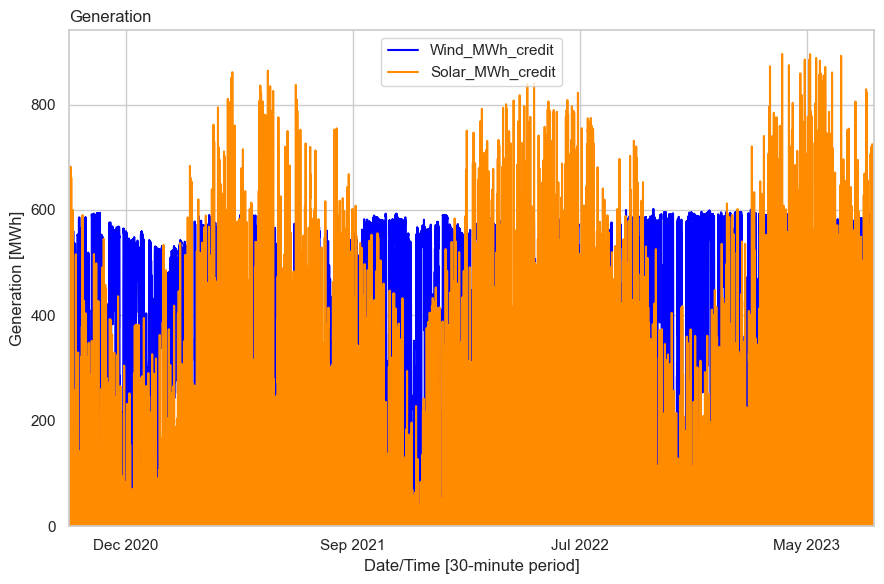

In [12]:
plt.figure(figsize=(9,6))
sns.set(style='whitegrid')
sns.color_palette("pastel", as_cmap=True)
ax2 = sns.lineplot(data=energy_data, x="dtm", y="Wind_MWh_credit",
                   label='Wind_MWh_credit', color='blue')
ax1 = sns.lineplot(data=energy_data, x="dtm", y="Solar_MWh_credit",
                   label='Solar_MWh_credit', color="darkorange")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax1.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax1.set_xlim(left=energy_data['dtm'].min(), right=energy_data['dtm'].max())
ax1.set_ylim(0)
plt.title("Generation", loc='left')
plt.xlabel("Date/Time [30-minute period]")
plt.ylabel("Generation [MWh]")
ax1.legend(loc='best')
plt.tight_layout()

## Merge Energy and Weather Data
We can merge the weather and energy data on their timestamps. Since we are only
interested in forecasting day-ahead, I'll also drop the longer lead-times from
the weather forecasts. A scatter plot of key weather variables against the wind
and solar generation illustrates the forecasting challenge: given a weather forecast,
how much energy do we expect to generate? Some data cleaning may be required...

In [13]:
modelling_table = dwd_Hornsea1_features.merge(dwd_solar_features,how="outer",on=["ref_datetime","valid_datetime"])
modelling_table = modelling_table.set_index("valid_datetime").groupby("ref_datetime").resample("30T").interpolate("linear")
modelling_table = modelling_table.drop(columns="ref_datetime",axis=1).reset_index()
modelling_table = modelling_table.merge(energy_data,how="inner",left_on="valid_datetime",right_on="dtm")
modelling_table = modelling_table[modelling_table["valid_datetime"] - modelling_table["ref_datetime"] < np.timedelta64(50,"h")]
modelling_table.rename(columns={"WindSpeed:100":"WindSpeed"},inplace=True)

Text(0, 0.5, 'Generation [MWh]')

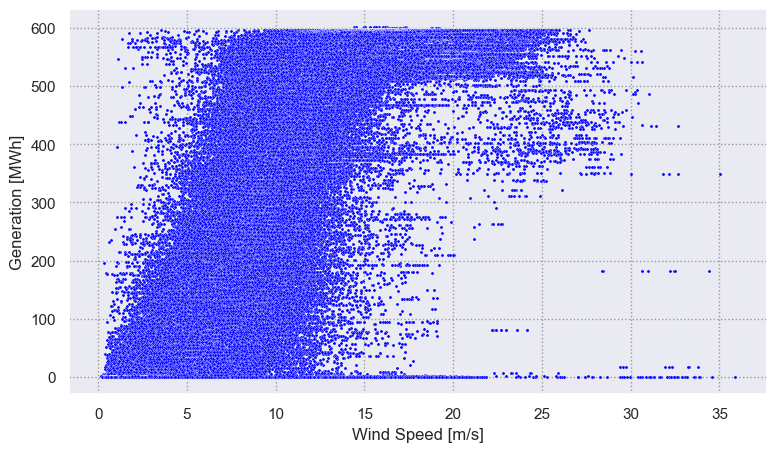

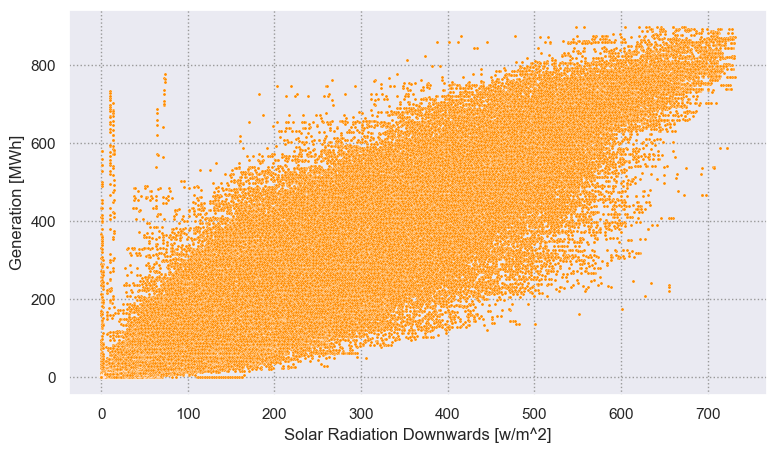

In [14]:
plt.figure(figsize=(9,5))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=modelling_table, x="WindSpeed", y="Wind_MWh_credit",
                color='blue',s=5)
plt.xlabel('Wind Speed [m/s]')
plt.ylabel('Generation [MWh]')
plt.figure(figsize=(9,5))
sns.scatterplot(data=modelling_table, x="SolarDownwardRadiation", 
                y="Solar_MWh_credit", color='darkorange',s=5)
plt.xlabel('Solar Radiation Downwards [w/m^2]')
plt.ylabel('Generation [MWh]')

## Modelling
Now we have joined all of our data we can fit a model to predict the total
energy production (wind + solar) for a given  weather forecast. The forecasting
track of the competition requires prediction of quantiles from 10% to 90% in
10% increments.

In this example, we'll throw away missing data and create a target variable
`total_generation_MWh`, but you could do something else.

In [15]:
modelling_table = modelling_table[modelling_table["SolarDownwardRadiation"].notnull()]
modelling_table = modelling_table[modelling_table["WindSpeed"].notnull()]
modelling_table["total_generation_MWh"] = modelling_table["Wind_MWh_credit"] + modelling_table["Solar_MWh_credit"]

This example uses splines and quantile regression to predict the `total_generation_MWh`
based on the `WindSpeed` and `SolarDownwardRadiation` features we created earlier. In
the loop below we fit a separate model for each quantile, and store the model in
a dictionary.

In [16]:
mod = smf.quantreg('total_generation_MWh ~ bs(SolarDownwardRadiation,df=5) + bs(WindSpeed,df=8)',
                   data=modelling_table)

forecast_models = dict()
for quantile in range(10,100,10):
    forecast_models[f"q{quantile}"] = mod.fit(q=quantile/100,max_iter=2500)
    modelling_table[f"q{quantile}"] = forecast_models[f"q{quantile}"].predict(modelling_table)
    modelling_table.loc[modelling_table[f"q{quantile}"] < 0, f"q{quantile}"] = 0

Lets save the models to to use later, including in automated
competition submissions. (These saved models are loaded and used to submit
forecast and market bids in the `auto_submitter.py` script.)

In [17]:
for quantile in range(10,100,10):
    forecast_models[f"q{quantile}"].save(f"models/model_q{quantile}.pickle")

Let's plot some of the predicted quantiles to see what our (in-sample) forecasts
look like. (Change `ref_datetime` to see forecasts produced at different times).

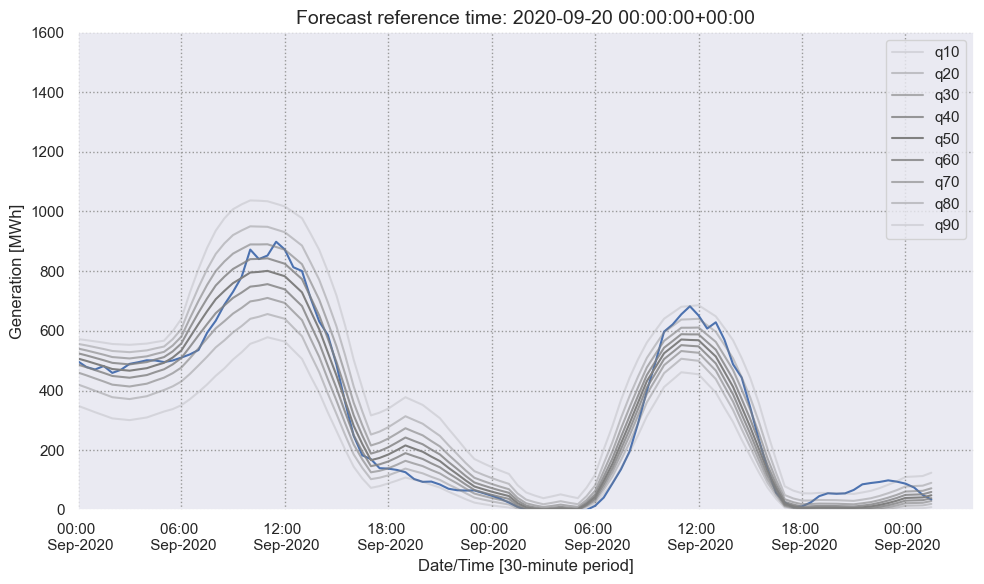

In [18]:
ref_time = modelling_table["ref_datetime"] == modelling_table["ref_datetime"][10]

plt.figure(figsize=(10,6))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax1 = sns.lineplot(data=modelling_table[ref_time], x="valid_datetime",
                   y="total_generation_MWh")

for quantile in range(10,100,10):
    sns.lineplot(data=modelling_table,
                 x=modelling_table[ref_time]["valid_datetime"],
                 y=modelling_table[ref_time][f"q{quantile}"],
                 color='gray',
                 alpha=1-abs(50-quantile)/50,
                 label=f'q{quantile}')

plt.ylim(0, 1600)
plt.xlim(modelling_table[ref_time]['valid_datetime'].min())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M \n %b-%Y"))
plt.xlabel('Date/Time [30-minute period]')
plt.ylabel('Generation [MWh]')
plt.title(f"Forecast reference time: {modelling_table[ref_time]['ref_datetime'][0]}",
          fontsize=14)
plt.tight_layout()


## Scoring
The forecasting track is scored using the Pinball (or Quantile) Score, averaged over quantiles from 10% to 90% in 10% increments and over time. The revenue track is scored according to cumulative revenue from the day-ahead and imbalance markets, taking into account the participant's influence on the imbalance price.

### Forecast scoring

The Pinball Score for the $\alpha$% predictive quantile $\hat{q}_\alpha$ and corresponding observation $y$ is given by
$$
L(y,\hat{q}_\alpha) = \begin{cases}
(y-\hat{q}_\alpha)\alpha &\text{if}~~~ y \ge \hat{q}_\alpha \\
(\hat{q}_\alpha -y)(1-\alpha) &\text{if}~~~ y < \hat{q}_\alpha

\end{cases}
$$
and the average score over quantiles $\alpha=10\%, 20\%,...,90\%$ and time periods will be used to determine rankings in the forecasting track of this competition.

Let's look at how the benchmark is performing using this metric.

In [19]:
def pinball(y,q,alpha):
    return (y-q)*alpha*(y>=q) + (q-y)*(1-alpha)*(y<q)

def pinball_score(df):
    score = list()
    for qu in range(10,100,10):
        score.append(pinball(y=df["total_generation_MWh"],
            q=df[f"q{qu}"],
            alpha=qu/100).mean())
    return sum(score)/len(score)

pinball_score(modelling_table)

29.414196581465255

Examining the pinball score in more detail can be helpful. If we look at how it varies with lead-time (how far ahead we are forecasting), as me might expect, we see that forecasts are better in the short-term, and gradually get worse the further ahead we try to predict. This competition focuses on forecasts made on the morning of day $D$ for each half-hour of day $D+1$, so this is where participants should focus their attention.

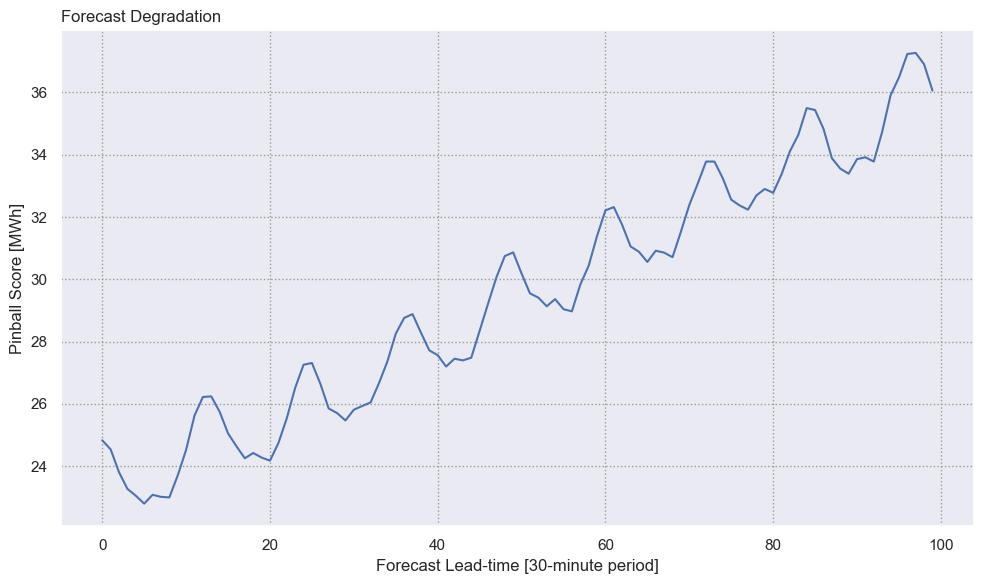

In [20]:
modelling_table['lead_time'] = modelling_table['valid_datetime'] - modelling_table['ref_datetime']

forecast_performance = modelling_table.groupby('lead_time').apply(pinball_score)

forecast_performance = modelling_table.groupby('lead_time').apply(pinball_score)
forecast_performance.index = forecast_performance.index.total_seconds() / (1800)

plt.figure(figsize=(10,6))
ax1 = forecast_performance.plot()
ax1.set_ylabel('Pinball Score [MWh]')
ax1.set_xlabel('Forecast Lead-time [30-minute period]', fontsize=12)
ax1.set_title('Forecast Degradation', loc='left')
plt.tight_layout()

### Revenue scoring

Revenue is calculated based on energy sold in the day-ahead market with any imbalance volume (the difference between energy sold day-ahead and what was actually generated) settled at the imbalance price. In practice, each market participant may influence the imbalance price, and that effect is included in how we will calculate revenue in this competition. See the documentation for more details. For a day-ahead market bid to sell $b$ MWh of energy in a given 30-minute period, and actual generation of $y$ MWh, revenue is calculated as
$$
    R = b \times \pi_D + (y-b) \times (\pi_S - 0.07 \times (y-b))
$$
where $\pi_D$ is the day-ahead market price (the "Intermittent Market Reference Price" here) and $\pi_S$ is the imbalance price from the real market. The effective imbalance price for each participant in the competition is $\pi_S - 0.07(y-b)$ to take into account their impact on the market.

The revenue track of the competition required participants to submit their day-ahead bids $b$ for each half-hour period of the day-ahead. To see how the scoring works we'll look at a simple *honest* strategy here of bidding our 50% forecast, i.e. $b=\hat{q}_{50\%}$. We'll look at a single day, 18 February, 2023. We need to select the weather (and energy) forecasts that would be available to us in time to make our submission (before 9:20AM UTC), and the half-hour periods of the day-ahead market we're submitting bids for, which runs from 11:00PM UK time on the same day to 10:30pm the following day. There is a function `day_ahead_market_times()` in the `comp_utils` module to help with this.

In [26]:
def revenue(bid,y,day_ahead_price,single_system_price):
    return bid*day_ahead_price + (y-bid)*(single_system_price - 0.07*(y-bid))

submission_date = "2023-02-18"
submission_date_forecast = modelling_table.loc[modelling_table["ref_datetime"]==pd.to_datetime(submission_date,utc=True)]
market_day = pd.DataFrame({"datetime":comp_utils.day_ahead_market_times(today_date=pd.to_datetime(submission_date))})
market_day = market_day.merge(submission_date_forecast,how="left",left_on="datetime",right_on="valid_datetime")
market_day["market_bid"] = market_day["q50"]

revenue(bid=market_day["market_bid"],
        y=market_day["total_generation_MWh"],
        day_ahead_price=market_day["DA_Price"],
        single_system_price=market_day["SS_Price"]).sum()

2240816.608637611

Looks good! But if you delve deeper you'll see that we didn't make money in every settlement period...

## Generate a competition submission

So far we have loaded historic data and fit models to predict the total wind 
and solar power generation. Now we'll look at how to retrieve the latest
weather forecast and submit our forecasts and market bids to the competition
platform.

The steps are as follows:

1. Retrieve the latest weather forecasts via the competition API
2. Calculate the features we need as inputs to our models
3. Generate our forecasts using the saved models
4. Wrangle our forecasts and market bids into the necessary format for submission
5. Submit via API!

These are the steps carried out in `auto_submitter.py`, which illustrates
how the process may be automated (see `README`).

This example is based on energy forecasting only, the market bid we'll submit
will be equal to the 50% quantile forecast. You might like to develop a more
sophisticated trading strategy using additional data and forecast of prices.
The competition API provides access to relevant data from the GB electricity
market, and you may make use of any other data you like as well. 

The `comp_utils` module includes an client to help access the API endpoints. We'll
use them to download the data and another function from `comp_utlis` to the response to `xarray` format to match the historic data we've used already. First, we need to set-up the client.

In [3]:
rebase_api_client = comp_utils.RebaseAPI(api_key = open("team_key.txt").read())

In [5]:
latest_dwd_Hornsea1 = comp_utils.weather_df_to_xr(rebase_api_client.get_hornsea_dwd())
latest_dwd_solar = comp_utils.weather_df_to_xr(rebase_api_client.get_pes10_nwp("DWD_ICON-EU"))

200
200


And then calculate our weather features and  merge the wind and solar data as before...

In [4]:
latest_dwd_Hornsea1_features = latest_dwd_Hornsea1["WindSpeed:100"].mean(dim=["latitude","longitude"]).to_dataframe().reset_index()
latest_dwd_solar_features = latest_dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()

latest_forecast_table = latest_dwd_Hornsea1_features.merge(latest_dwd_solar_features,how="outer",on=["ref_datetime","valid_datetime"])
latest_forecast_table = latest_forecast_table.set_index("valid_datetime").resample("30T").interpolate("linear",limit=5).reset_index()

latest_forecast_table.rename(columns={"WindSpeed:100":"WindSpeed"},inplace=True)

Now we can load our forecast models and add the predictive quantiles of total
wind and solar generation to the `latest_forecast_table`. (We could also use
the models stored in the `forecast_models` dictionary, as in two commented out
lines.)

In [5]:
for quantile in range(10,100,10):
    loaded_model = load_pickle(f"models/model_q{quantile}.pickle")
    latest_forecast_table[f"q{quantile}"] = loaded_model.predict(latest_forecast_table)
    
    # latest_forecast_table[f"q{quantile}"] = forecast_models[f"q{quantile}"].predict(latest_forecast_table)
    # latest_forecast_table.loc[latest_forecast_table[f"q{quantile}"] < 0, f"q{quantile}"] = 0


Let's have a look at a plot of out energy generation forecast based on the
latest weather forecasts to make sure everything is as expected. 

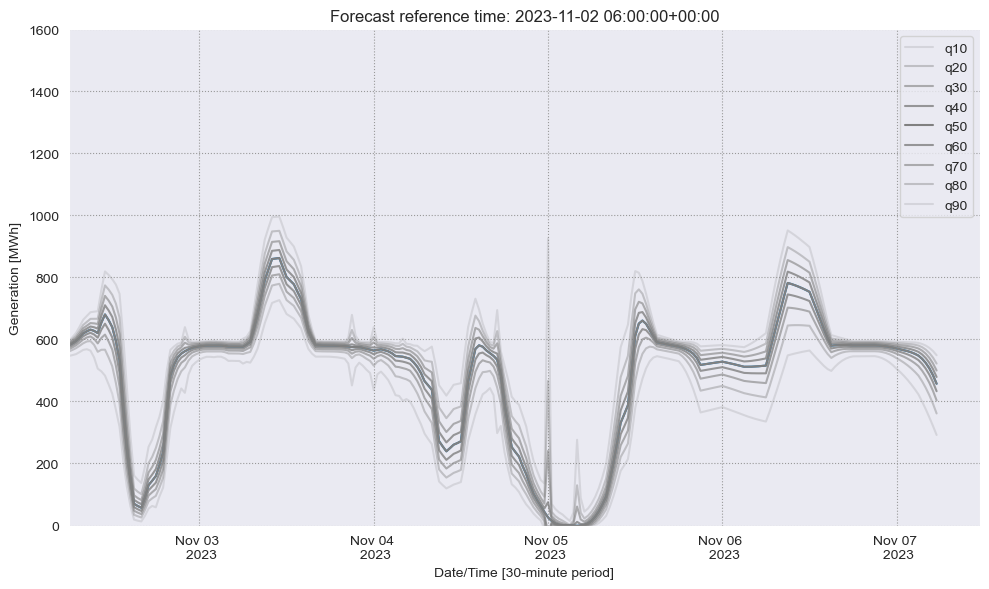

In [6]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax1 = sns.lineplot(data=latest_forecast_table, x="valid_datetime",
                   y="q50")

for quantile in range(10,100,10):
    sns.lineplot(data=latest_forecast_table,
                 x=latest_forecast_table["valid_datetime"],
                 y=latest_forecast_table[f"q{quantile}"],
                 color='gray',
                 alpha=1-abs(50-quantile)/50,
                 label=f'q{quantile}')
plt.title(f"Forecast reference time: {latest_forecast_table['ref_datetime'][0]}"
          )
plt.xlabel('Date/Time [30-minute period]')
plt.ylabel('Generation [MWh]')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %d \n %Y"))
plt.ylim(0, 1600)
plt.xlim(latest_forecast_table['valid_datetime'].min())
plt.tight_layout()
plt.show()

Finally, we need to wrangle our forecast into the correct format the submit
to the competition platform. Some tools are provided in the `comp_utils` module
to help, but you MUST be sure you're submission are correct and take full
responsibility for them.

The day-ahead electricity market in Great Britain is synchronised with the European
market, which runs from midnight to midnight in the CET/CEST timezone. We must submit
bids for each half-hour of this time range. Submissions must be made before
gate closure for the day-ahead market at 9:20am GMT.

The function `comp_utils.day_ahead_market_times()` creates a pandas DataFrame
with the correct timestamps, which handle the transition to and from daylight
saving. (March 31 2024 only contains be 23 hours!!!)

As we are using timezone-aware timestamps, we can make sure to submit the correct
forecasts and bids by merging onto the DataFrame created by `comp_utils.day_ahead_market_times()`.
In this example, our market bid will be equal to our 50% quantile forecast.

The function `comp_utils.prep_submission_in_json_format()` converts out `submission_data`
into the correct format (using column names `datetime`,`q10`,...,`q90` and `market_bid`).

The function `comp_utils.submit()` will send our data to the competition platform and
print the response from the API.

In [7]:

submission_data=pd.DataFrame({"datetime":comp_utils.day_ahead_market_times()})
submission_data = submission_data.merge(latest_forecast_table,how="left",left_on="datetime",right_on="valid_datetime")
submission_data["market_bid"] = submission_data["q50"]

submission_data = comp_utils.prep_submission_in_json_format(submission_data)
print(submission_data)

rebase_api_client.submit(submission_data)

{'market_day': '2023-11-03', 'submission': [{'timestamp': '2023-11-02T23:00:00+00:00', 'market_bid': 572.7253655225895, 'probabilistic_forecast': {10: 514.9306795201529, 20: 545.4367627895082, 30: 557.6204063160585, 40: 565.9405729721318, 50: 572.7253655225895, 60: 578.1185678735595, 70: 583.2547438919116, 80: 587.9363141012658, 90: 592.4365393160479}}, {'timestamp': '2023-11-02T23:30:00+00:00', 'market_bid': 575.423705844886, 'probabilistic_forecast': {10: 526.1150956313637, 20: 552.0153839585957, 30: 562.1140940238757, 40: 569.3504669437791, 50: 575.423705844886, 60: 580.1291057490417, 70: 584.6238958078674, 80: 588.7914185172347, 90: 592.7871734466852}}, {'timestamp': '2023-11-03T00:00:00+00:00', 'market_bid': 577.5562663984167, 'probabilistic_forecast': {10: 534.6755248401239, 20: 556.8005021671695, 30: 565.3868698091054, 40: 571.9202143449338, 50: 577.5562663984167, 60: 581.7977131230928, 70: 585.8492758875753, 80: 589.6870654878679, 90: 593.343884343604}}, {'timestamp': '2023-11-

## Usage of other API Endpoints

Let's take a look at some of the other API endpoints that provide useful data, e.g. to update our training dataset with recent data, or providing additional data from the electricity market that could inform our trading strategy. Detailed documentation is available on the [IEEE DataPort Page](https://ieee-dataport.org/competitions/hybrid-energy-forecasting-and-trading-competition) and [rebase.energy API docs page](https://api.rebase.energy/challenges/redoc).

Let's grab some historic data and check it matches what we already have from `data/Energy_Data*.csv`...

In [4]:
test_date = "2023-07-01"

rebase_api_client.get_wind_production(day=test_date)

rebase_api_client.get_solar_production(
    from_date=pd.to_datetime(test_date).tz_localize("Europe/London"),
    to_date=pd.to_datetime(test_date).tz_localize("Europe/London") + pd.Timedelta(1,unit="day"))

,timestamp_utc,generation_mw,installed_capacity_mwp,capacity_mwp
0,2023-06-30T23:00:00Z,0.000000,2486.921962,2337.607243
1,2023-06-30T23:30:00Z,0.000000,2486.921962,2337.607243
2,2023-07-01T00:00:00Z,0.000000,2486.921962,2337.607243
3,2023-07-01T00:30:00Z,0.000000,2486.921962,2337.607243
4,2023-07-01T01:00:00Z,0.000000,2486.921962,2337.607243
5,2023-07-01T01:30:00Z,0.000000,2486.921962,2337.607243
6,2023-07-01T02:00:00Z,0.000000,2486.921962,2337.607243
7,2023-07-01T02:30:00Z,0.000000,2486.921962,2337.607243
8,2023-07-01T03:00:00Z,0.000000,2486.921962,2337.607243
9,2023-07-01T03:30:00Z,0.001385,2486.921962,2337.607243


In [10]:
energy_data.loc[
    (energy_data["dtm"] >= pd.to_datetime(test_date).tz_localize("Europe/London")) &
    (energy_data["dtm"] < pd.to_datetime(test_date).tz_localize("Europe/London") + pd.Timedelta(1,unit="day"))
    ]

,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,Wind_MWh_credit,Solar_MWh_credit
49229,2023-06-30 23:00:00+00:00,40.11,0.000000,2337.607243,2486.921962,1071.622,30.04000,0.0,77.93,535.811,0.000000
49230,2023-06-30 23:30:00+00:00,28.43,0.000000,2337.607243,2486.921962,1072.582,22.60000,0.0,77.93,536.291,0.000000
49231,2023-07-01 00:00:00+00:00,-2.37,0.000000,2337.607243,2486.921962,1037.922,10.00000,0.0,65.90,518.961,0.000000
49232,2023-07-01 00:30:00+00:00,-5.06,0.000000,2337.607243,2486.921962,1017.762,-6.91000,0.0,65.90,508.881,0.000000
49233,2023-07-01 01:00:00+00:00,-15.12,0.000000,2337.607243,2486.921962,929.202,-27.91067,0.0,54.04,464.601,0.000000
49234,2023-07-01 01:30:00+00:00,-22.23,0.000000,2337.607243,2486.921962,918.522,-26.00000,0.0,54.04,459.261,0.000000
49235,2023-07-01 02:00:00+00:00,-22.28,0.000000,2337.607243,2486.921962,957.262,-24.00000,0.0,43.57,478.631,0.000000
49236,2023-07-01 02:30:00+00:00,-25.25,0.000000,2337.607243,2486.921962,1004.362,-25.00000,0.0,43.57,502.181,0.000000
49237,2023-07-01 03:00:00+00:00,-19.38,0.000000,2337.607243,2486.921962,1065.002,-16.00000,0.0,39.46,532.501,0.000000
49238,2023-07-01 03:30:00+00:00,-24.24,0.001385,2337.607243,2486.921962,1060.582,-20.00000,0.0,39.46,530.291,0.000692
